Import files

In [1]:
import os
import numpy as np
import pandas as pd
import torch

def read_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            mass, intensity = line.strip().split('\t')
            data.append([float(mass), float(intensity)])
    return np.array(data)

directory = r'C:\Users\Marshall\TEST DATA\TEST DATA\DalbergiaLatifolia'
file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_data = []
for file_path in file_paths:
    data = pd.read_csv(file_path,sep= '\t',header = 1)
    all_data.append(data)




Scale the data

In [2]:
all_data_scaled = []
for seq in all_data:
    seq = np.array(seq)
    mass_values = seq[:, 0]
    intensity_values = seq[:, 1]

    # Calculate the minimum and maximum intensity values for this sequence
    intensity_min = np.min(intensity_values)
    intensity_max = np.max(intensity_values)

    # Scale the intensity values using the max-min scaler
    scaled_intensity = (intensity_values - intensity_min) / (intensity_max - intensity_min)

    # Combine the scaled intensity values with the mass values
    scaled_seq = np.column_stack((mass_values, scaled_intensity))

    all_data_scaled.append(scaled_seq)

In [3]:
from torch.nn.utils.rnn import pad_sequence

#all_data_scaled = np.concatenate(all_data_scaled, axis=0)

max_seq_len = max(len(seq) for seq in all_data)

# Create a list of tensors for each sequence in the dataset
tensor_data = [torch.tensor(seq, dtype=torch.float32) for seq in all_data_scaled]

# Pad the sequences
padded_data = pad_sequence(tensor_data, batch_first=True, padding_value=0.0)


In [4]:
features = padded_data[:, :, 0].unsqueeze(-1)  # Mass values
targets = padded_data[:, :, 1].unsqueeze(-1)   # Intensity values

In [5]:
# Create a mask tensor for the features
features_mask = torch.ones_like(features, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    features_mask[i, len(seq):, 0] = False

# Create a mask tensor for the targets
targets_mask = torch.ones_like(targets, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    targets_mask[i, len(seq):, 0] = False


VAE setup

In [20]:
import torch
import torch.nn as nn

class RecurrentVAE(nn.Module):
    def __init__(self, feature_dim, target_dim, latent_dim, hidden_dim, num_layers, dropout_rate):
        super(RecurrentVAE, self).__init__()
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Encoder
        self.encoder_rnn = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.encoder_residual = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # Residual connection
        self.attention_linear = nn.Linear(hidden_dim * 2, 1)
        self.attention_pool = nn.AdaptiveAvgPool1d(1)
        self.mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.log_var = nn.Linear(hidden_dim * 2, latent_dim)

        # Variational Dropout
        self.variational_dropout = nn.Dropout(p=dropout_rate)

        # Decoder
        self.decoder_rnn = nn.LSTM(latent_dim + hidden_dim * 2, hidden_dim, num_layers, batch_first=True)
        self.decoder_residual = nn.Linear(hidden_dim, hidden_dim)  # Residual connection
        self.decoder_out = nn.Linear(hidden_dim, target_dim)

    def encode(self, features, mask=None):
        # print("Features shape:", features.shape)
        encoder_outputs, (h_n, _) = self.encoder_rnn(features)
        # print("Encoder outputs shape:", encoder_outputs.shape)
        # print("h_n shape:", h_n.shape)
    
        if mask is not None:
            # print("Mask shape:", mask.shape)
            encoder_outputs = encoder_outputs * mask
            # print("Masked encoder outputs shape:", encoder_outputs.shape)

        # Apply variational dropout to encoder outputs
        encoder_outputs = self.variational_dropout(encoder_outputs)

        # Apply residual connection
        encoder_outputs = encoder_outputs + self.encoder_residual(encoder_outputs)

        # Compute intensity-based attention weights from targets
        attention_weights = self.attention_linear(encoder_outputs)
        # print("Attention weights shape:", attention_weights.shape)  
        attention_weights = torch.softmax(attention_weights, dim=1)
        # print("Attention weights shape:", attention_weights.shape)
        
        # Compute attention-weighted representations
        attention_weighted_outputs = attention_weights * encoder_outputs
        # print("Attention-weighted outputs shape:", attention_weighted_outputs.shape)

        h_n = self.attention_pool(attention_weighted_outputs.transpose(1, 2)).squeeze(-1)
        #h_n = h_n.view(self.num_layers, -1, self.hidden_dim)[-1]
        # print("Reshaped h_n shape:", h_n.shape)
    
        mu = self.mu(h_n)
        log_var = self.log_var(h_n)
        return mu, log_var, attention_weighted_outputs

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, attention_weighted_outputs, seq_len):
        # Concatenate latent vector and attention-weighted representations
        decoder_input = torch.cat((z.unsqueeze(1).repeat(1, seq_len, 1), attention_weighted_outputs), dim=-1)
        
        outputs, _ = self.decoder_rnn(decoder_input)

        # Apply variational dropout to decoder outputs
        outputs = self.variational_dropout(outputs)

        # Apply residual connection
        outputs = outputs + self.decoder_residual(outputs)
        
        recon_targets = self.decoder_out(outputs)
        return recon_targets

    def forward(self, features, targets, mask=None):
        # print("Features shape:", features.shape)
        # print("Targets shape:", targets.shape)
        if mask is not None:
            features_mask, targets_mask = mask
        else:
            features_mask, targets_mask = None, None
        mu, log_var, attention_weighted_outputs = self.encode(features, mask=features_mask)
        # print("Mu shape:", mu.shape)
        # print("Log-variance shape:", log_var.shape)
        z = self.reparameterize(mu, log_var)
        # print("Reparameterized z shape:", z.shape)
        seq_len = targets.size(1)
        targets_recon = self.decode(z, attention_weighted_outputs,seq_len)
        # print("Reconstructed targets shape:", targets_recon.shape)

        if targets_mask is not None:
            targets_recon = targets_recon * targets_mask

        return targets_recon, mu, log_var

Training the VAE

In [32]:
import torch
import torch.nn.functional as F

# Instantiate the model
vae = RecurrentVAE(feature_dim=1, target_dim=1, latent_dim=64, hidden_dim=128, num_layers=3, dropout_rate=0.2 )  

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

# Move the data to GPU (if available)
features = features.to(device)
targets = targets.to(device)
features_mask = features_mask.to(device)
targets_mask = targets_mask.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
reconstruction_loss = F.mse_loss

# Training loop
num_epochs = 10000
batch_size = 7
# Set the gradient clipping threshold
clip_threshold = 5.0
train_losses = []

# Set the regularization strengths
# l1_lambda = 0.001
# l2_lambda = 0.001

for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    # total_l1_reg = 0
    # total_l2_reg = 0
    num_batches = 0

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i+batch_size]
        batch_targets = targets[i:i+batch_size]
        batch_features_mask = features_mask[i:i+batch_size]
        batch_targets_mask = targets_mask[i:i+batch_size]

        # print("Batch features shape:", batch_features.shape)
        # print("Batch targets shape:", batch_targets.shape)
        # print("Batch features mask shape:", batch_features_mask.shape)
        # print("Batch targets mask shape:", batch_targets_mask.shape)

        optimizer.zero_grad()

        targets_recon, mu, log_var = vae(batch_features, batch_targets,
                                         mask=(batch_features_mask, batch_targets_mask))

        # Compute the reconstruction loss
        recon_loss = reconstruction_loss(targets_recon * batch_targets_mask,
                                         batch_targets * batch_targets_mask,
                                         reduction='sum')

        # Compute the KL divergence loss
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # # L1/L2 regularization
        # l1_reg = 0
        # l2_reg = 0
        # for param in vae.parameters():
        #     l1_reg += torch.sum(torch.abs(param))
        #     l2_reg += torch.sum(torch.square(param))


        loss = recon_loss + kl_div

        loss.backward()

        # Clip the gradients
        torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_threshold)
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_div.item()
        # total_l1_reg += l1_reg.item()
        # total_l2_reg += l2_reg.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    train_losses.append(avg_loss)
    avg_kl_div = total_kl_div / num_batches
    # avg_l1_reg = total_l1_reg / num_batches
    # avg_l2_reg = total_l2_reg / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {avg_recon_loss:.4f}, KL Div: {avg_kl_div:.4f}")

Epoch [1/10000], Recon Loss: 38.5819, KL Div: 0.3498
Epoch [2/10000], Recon Loss: 25.4241, KL Div: 0.3146
Epoch [3/10000], Recon Loss: 24.0952, KL Div: 0.2834
Epoch [4/10000], Recon Loss: 23.4655, KL Div: 0.2514
Epoch [5/10000], Recon Loss: 20.1266, KL Div: 0.2181
Epoch [6/10000], Recon Loss: 23.5749, KL Div: 0.1808
Epoch [7/10000], Recon Loss: 19.3726, KL Div: 0.1447
Epoch [8/10000], Recon Loss: 19.4340, KL Div: 0.1054
Epoch [9/10000], Recon Loss: 19.5273, KL Div: 0.0635
Epoch [10/10000], Recon Loss: 18.7045, KL Div: 0.0288
Epoch [11/10000], Recon Loss: 18.5758, KL Div: 0.0103
Epoch [12/10000], Recon Loss: 18.6322, KL Div: 0.0060
Epoch [13/10000], Recon Loss: 18.6951, KL Div: 0.0060
Epoch [14/10000], Recon Loss: 18.5000, KL Div: 0.0052
Epoch [15/10000], Recon Loss: 18.4615, KL Div: 0.0035
Epoch [16/10000], Recon Loss: 18.4399, KL Div: 0.0019
Epoch [17/10000], Recon Loss: 18.2517, KL Div: 0.0010
Epoch [18/10000], Recon Loss: 18.2457, KL Div: 0.0004
Epoch [19/10000], Recon Loss: 18.2706

Create output

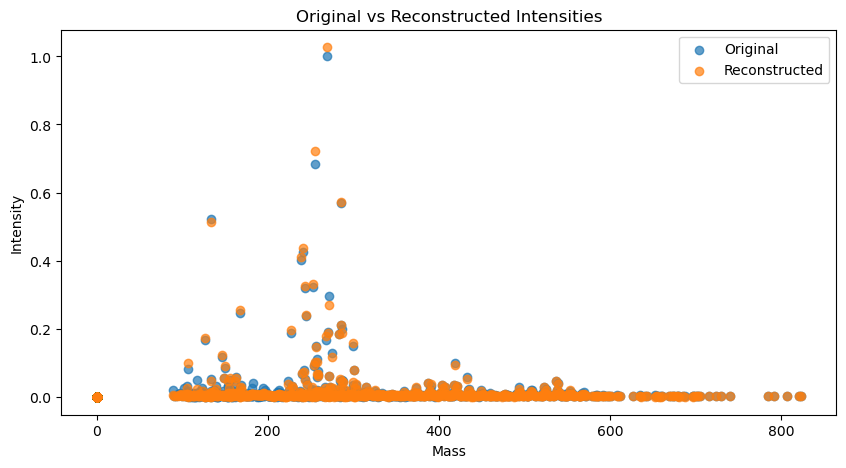

In [34]:
import matplotlib.pyplot as plt

# Remove the mask from the features, targets, and reconstructed targets
original_features = batch_features.detach().cpu().numpy().squeeze()
original_targets = batch_targets.detach().cpu().numpy().squeeze()
reconstructed_targets = targets_recon.detach().cpu().numpy().squeeze()
reconstructed_features = batch_features.detach().cpu().numpy().squeeze()
# Plot the original and reconstructed targets against the original features
plt.figure(figsize=(10, 5))
plt.scatter(original_features, original_targets, label='Original', alpha=0.7)
plt.scatter(reconstructed_features, reconstructed_targets, label='Reconstructed', alpha=0.7)
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.title('Original vs Reconstructed Intensities')
plt.show()

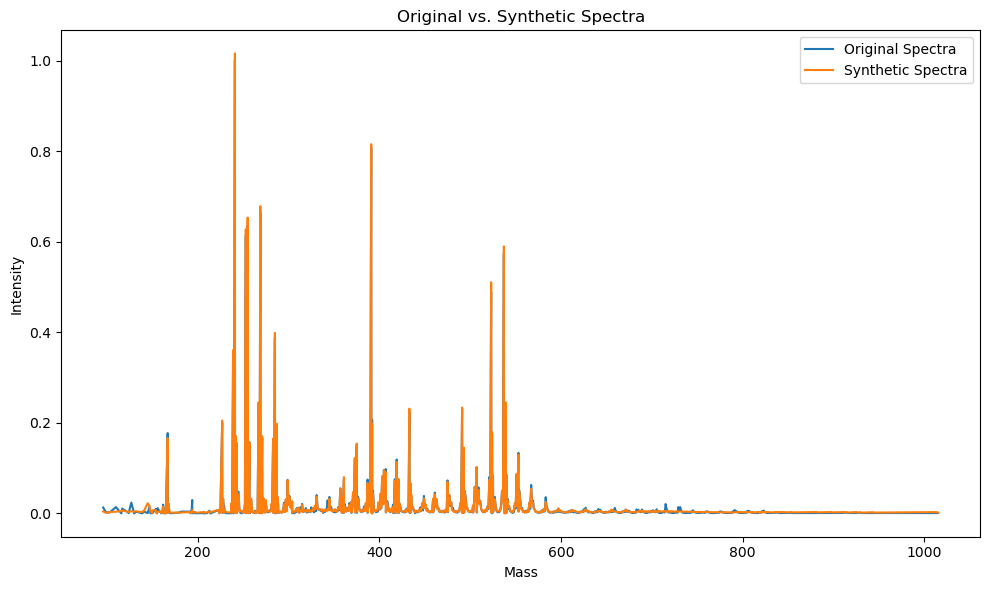

In [35]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
vae.eval()

# Select a spectra from your dataset
index = 0  # Choose the index of the spectra you want to plot
original_features = features[index]
original_targets = targets[index]

latent_dim = 35

# Generate a synthetic spectra using your model
with torch.no_grad():
    latent_sample = torch.randn(1, latent_dim)  # Generate a random latent sample
    synthetic_targets, _, _ = vae(original_features.unsqueeze(0), original_targets.unsqueeze(0))

# Remove padding from the original and synthetic spectra
original_features = original_features[features_mask[index]]
original_targets = original_targets[targets_mask[index]]
synthetic_targets = synthetic_targets.squeeze()[:len(original_targets)]

# Plot the original and synthetic spectra
plt.figure(figsize=(10, 6))

# Plot the original spectra
plt.plot(original_features.cpu().numpy(), original_targets.cpu().numpy(), label='Original Spectra')

# Plot the synthetic spectra
plt.plot(original_features.cpu().numpy(), synthetic_targets.cpu().numpy(), label='Synthetic Spectra')

plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.title('Original vs. Synthetic Spectra')
plt.legend()
plt.tight_layout()
plt.show()

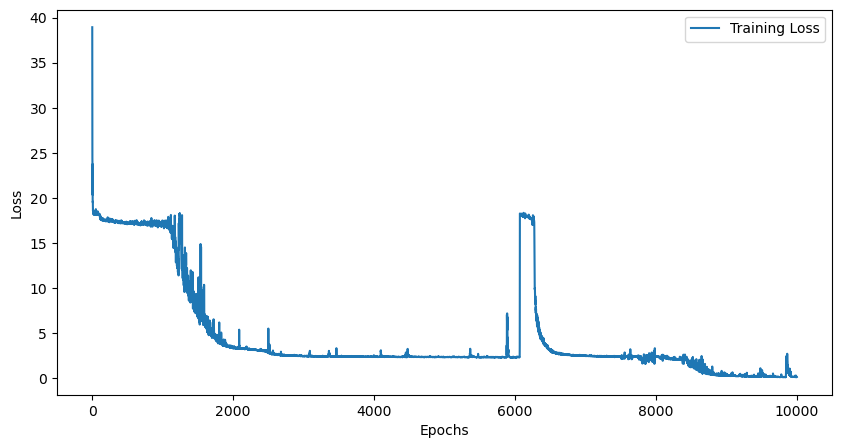

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

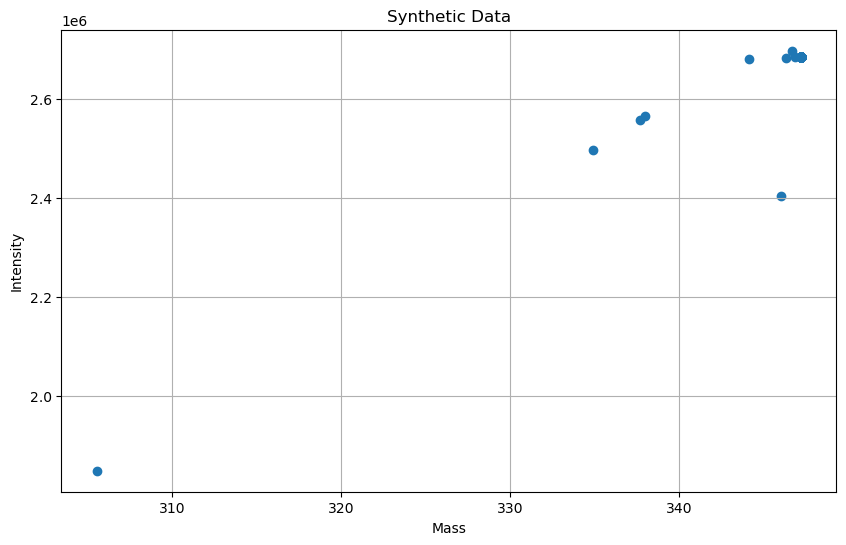

In [30]:
# Denormalize the synthetic data
synthetic_data = synthetic_data.cpu().detach().numpy()
denormalized_samples = (synthetic_data * stds) + means

# Save the synthetic data
np.savetxt('synthetic_data.txt', denormalized_samples, delimiter='\t')

# Visualize the synthetic data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(denormalized_samples[:, 0], denormalized_samples[:, 1])
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.title('Synthetic Data')
plt.grid(True)
plt.show()

# Save the model
torch.save(vae.state_dict(), 'vae_model.pth')


